In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e0039622-5be6-2bec-4273-201d0e950e7b)
GPU 1: Tesla T4 (UUID: GPU-05e9dff4-cd6d-fda3-b1ea-eabf4014b4c0)


**SkimLit is a NLP project which takes a paragraph as input and split it into a easily understandable format. It classifies the different sentences of the paragraph into 5 different classes namely:  ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'].\n
 Main Modules/library used are as : Tensorflow, Scikitlearn, Pandas, Matplotlib, Spacy, etc.
 Process involves are as :\n
 1.) Preprocessing train files ,\n
 2.) Data exploration and visualization,\n
 3.) Text Vectorization and Token Embedding,\n
 4.) Use of feature training(Use of pretrained token embedding layer from Tensorflow Hub),\n
 5.) Formation of a tribid model(Pretrained token embedding + character embedding + poitional   embedding),\n
 6.) Checking the results of the model (Note: We are not using the Glove embedding here , so if our model's accuracy reached >80% we would make predictions on it using out test data and check results),\n
 7.) Make predictions on the paragraphs from the wild.**

**a.) Get the data**

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 36.50 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


**b.) See the filenames**

In [3]:
data_dir = '/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

**Read the files**

In [4]:
def open_file(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [5]:
train_lines = open_file('/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

**create a function to convert data into much readable manner**

In [6]:
def preprocess_text_with_line_numbers(filename):
    input_lines = open_file(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1]
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples    

In [7]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [8]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


**create text data for pretrained embedding**

In [9]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

**encode the labels**

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
train_labels_encoded

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([3, 2, 2, ..., 4, 1, 1])

In [11]:
classes = label_encoder.classes_
num_classes = len(label_encoder.classes_)
num_classes, classes

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

**one hot encode the labels**

In [12]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

**function to create char level data**

In [13]:
def char_split(text):
    return " ".join(list(text))

In [14]:
train_char = [char_split(sentence) for sentence in train_sentences]
val_char = [char_split(sentence) for sentence in val_sentences]
train_char[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [15]:
import numpy as np
char_len = [len(sentence) for sentence in train_char]
avg_char_len = np.mean(char_len)
avg_char_len

297.7325149966674

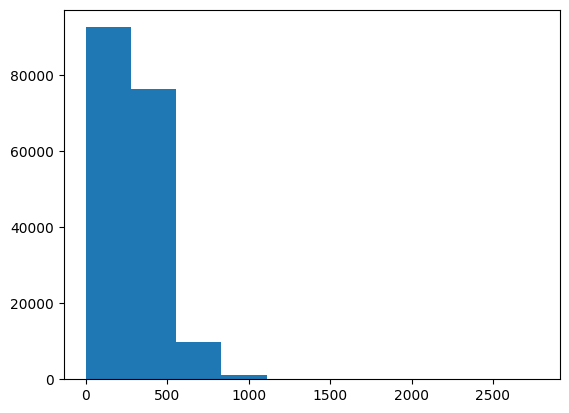

In [16]:
import matplotlib.pyplot as plt
plt.hist(char_len);

In [17]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

579

In [18]:
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

**Vectorization for char level data**

In [19]:
import tensorflow as tf
char_vectorization = tf.keras.layers.TextVectorization(max_tokens = len(alphabets) + 2,
                                                      output_sequence_length = output_seq_char_len)
char_vectorization.adapt(train_char)

In [20]:
char_vocab = char_vectorization.get_vocabulary()
len(char_vocab)

28

**cerate char embedding layer**

In [21]:
char_embedding = tf.keras.layers.Embedding(input_dim = len(char_vocab),
                                          output_dim = 24,
                                          mask_zero = True)
char_embedding(char_vectorization(['i l o v e y o u']))

<tf.Tensor: shape=(1, 579, 24), dtype=float32, numpy=
array([[[-0.03643885,  0.0417927 ,  0.03214297, ..., -0.02088444,
          0.0197115 ,  0.04812494],
        [ 0.00201471,  0.01748652,  0.02710069, ..., -0.01895697,
          0.00653324,  0.01680304],
        [-0.01451156, -0.01332003, -0.02038932, ..., -0.00253203,
          0.04779979, -0.03145138],
        ...,
        [-0.02100201, -0.03127517, -0.00338393, ...,  0.02714844,
         -0.03056504, -0.02700198],
        [-0.02100201, -0.03127517, -0.00338393, ...,  0.02714844,
         -0.03056504, -0.02700198],
        [-0.02100201, -0.03127517, -0.00338393, ...,  0.02714844,
         -0.03056504, -0.02700198]]], dtype=float32)>

**Extarct pretrained feature extraction layer**

In [22]:
import tensorflow_hub as hub
tf_pretrained_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                              trainable = False)

In [23]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


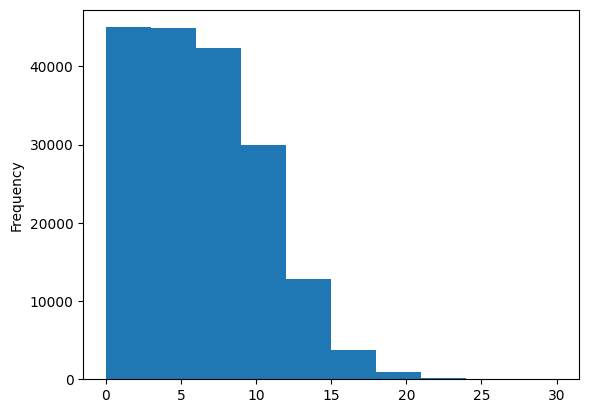

In [24]:
train_df.line_number.plot.hist();

**** Create positional data****

In [25]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
train_line_number_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

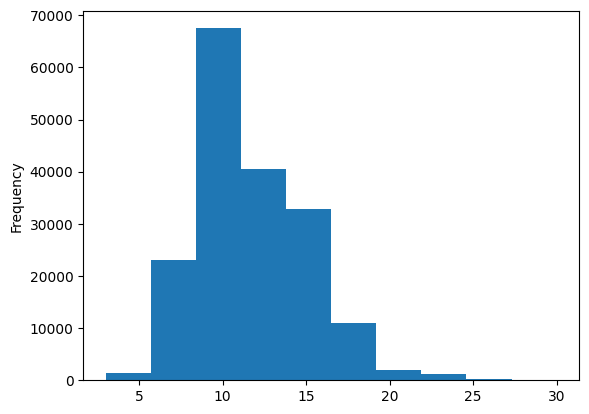

In [26]:
train_df.total_lines.plot.hist();

In [27]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

**Make datasets for the fitting**

In [28]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_char))
train_char_token_pos_label =tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_label))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

**Model: It is a tribrid model which contains four smaller models i.e. Token pretrained embedding model, Character embedding model and two positional embedding model.**

In [29]:
# create token model:
token_input = tf.keras.layers.Input(shape = [], dtype = tf.string, name = 'token_input_layer')
token_pretrained_embedding = tf_pretrained_embedding_layer(token_input)
token_output = tf.keras.layers.Dense(128, activation = 'relu')(token_pretrained_embedding)
token_model = tf.keras.Model(token_input, token_output)

# create char model:
char_input = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = 'char_input_layer')
char_vectors = char_vectorization(char_input)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_input, char_bi_lstm)

# line number input:
line_number_input = tf.keras.layers.Input(shape = (15,), dtype = tf.float32,name = 'line_number_input_layer')
x = tf.keras.layers.Dense(32, activation = 'relu')(line_number_input)
line_number_model = tf.keras.Model(line_number_input, x)

# total lines model:
total_lines_input = tf.keras.layers.Input(shape = (20,), dtype = tf.float32,name = 'total_lines_input_layer')
y = tf.keras.layers.Dense(32, activation = 'relu')(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, y)

#  combine token and char embeddings into hybrid model:
combined_embeddings = tf.keras.layers.Concatenate(name ='hybrid_embeddings')([token_model.output, char_model.output])
z = tf.keras.layers.Dense(256, activation = 'relu')(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# combine positional, char and combine embeddings:
tribrid_embeddings = tf.keras.layers.Concatenate(name = 'tribrid_embeddings')([line_number_model.output, total_lines_model.output, z])

# create output layer:
output_layer = tf.keras.layers.Dense(5, activation = 'softmax', name = 'output_layer')(tribrid_embeddings)

# put together:
model = tf.keras.Model(inputs = [line_number_model.input, total_lines_model.input, token_model.input, char_model.input], outputs = output_layer)

In [30]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input_layer (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 token_input_layer (InputLa  [(None,)]                    0         []                            
 yer)                                                                                             
                                                                                                  
 text_vectorization (TextVe  (None, 579)                  0         ['char_input_layer[0][0]']    
 ctorization)                                                                               

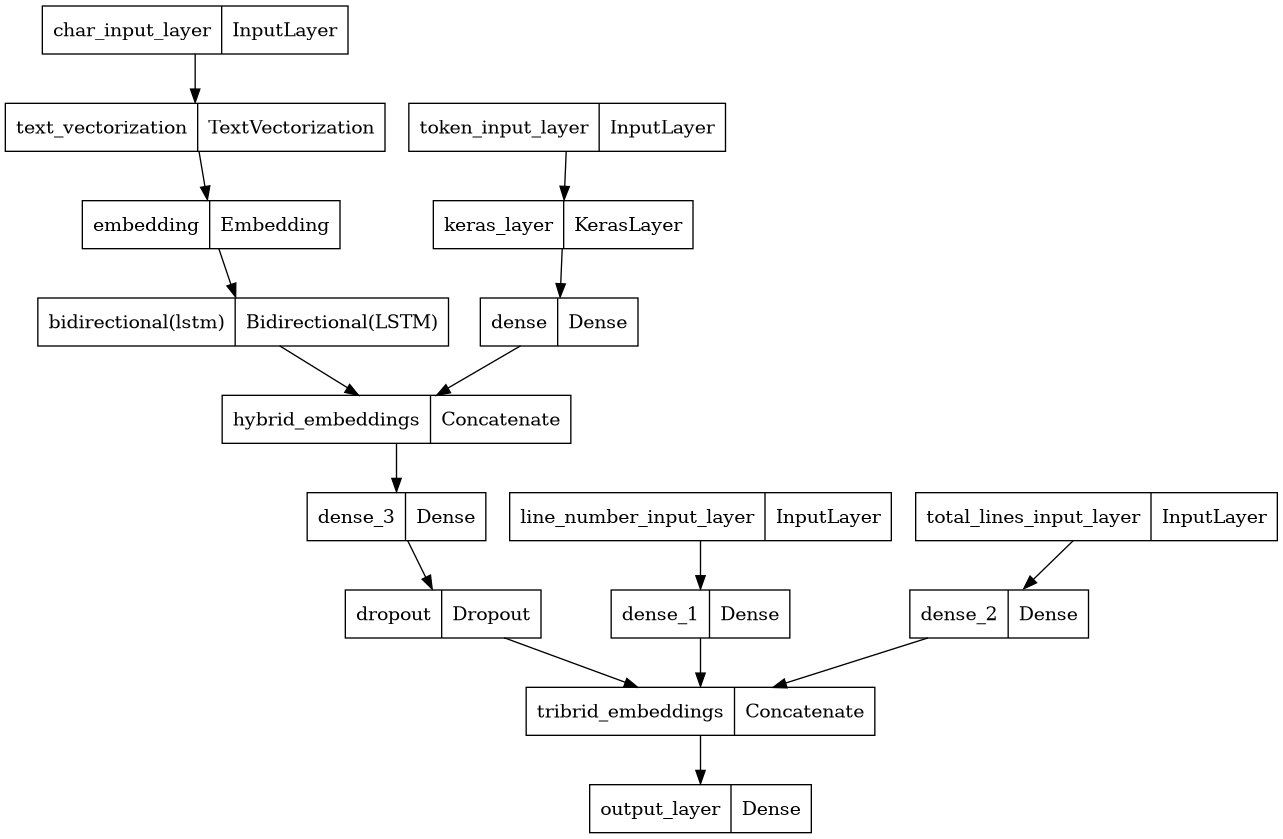

In [31]:
from keras.utils import plot_model
plot_model(model)

**Create a model which gives out accuracy of our model**

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_result(y_true, y_preds):
    model_accuracy = accuracy_score(y_true, y_preds)
    model_precision, model_recall, model_f1score, _ = precision_recall_fscore_support(y_true, y_preds, average = 'weighted')
    model_results = {'accuracy': model_accuracy,
                     'precision': model_precision,
                     'recall': model_recall,
                     'f1_score': model_f1score}
    return model_results
    

In [33]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

**create a early stopping callback**

In [34]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 patience = 3,
                                                 restore_best_weights = True)

**Make validation dataset**

In [35]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_char))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

**Fit the model**

In [36]:
history = model.fit(train_char_token_pos_dataset,
                    epochs = 20,
                    steps_per_epoch = int(0.2 * len(train_char_token_pos_dataset)),
                    validation_data = val_char_token_pos_dataset,
                    validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                    callbacks = early_callback)

Epoch 1/20
1125/1125 [==============================] - 73s 51ms/step - loss: 0.6357 - accuracy: 0.7586 - val_loss: 0.4756 - val_accuracy: 0.8208
Epoch 2/20
1125/1125 [==============================] - 50s 44ms/step - loss: 0.4581 - accuracy: 0.8239 - val_loss: 0.4296 - val_accuracy: 0.8348
Epoch 3/20
1125/1125 [==============================] - 48s 43ms/step - loss: 0.4329 - accuracy: 0.8330 - val_loss: 0.3992 - val_accuracy: 0.8497
Epoch 4/20
1125/1125 [==============================] - 56s 50ms/step - loss: 0.4073 - accuracy: 0.8447 - val_loss: 0.3769 - val_accuracy: 0.8574
Epoch 5/20
1125/1125 [==============================] - 52s 46ms/step - loss: 0.4021 - accuracy: 0.8464 - val_loss: 0.3870 - val_accuracy: 0.8527
Epoch 6/20
1125/1125 [==============================] - 2s 2ms/step - loss: 0.4680 - accuracy: 0.7250 - val_loss: 0.3896 - val_accuracy: 0.8504


In [37]:
model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.3814 - accuracy: 0.8515


[0.38143041729927063, 0.8514828681945801]

**Function for graphical evaluation**

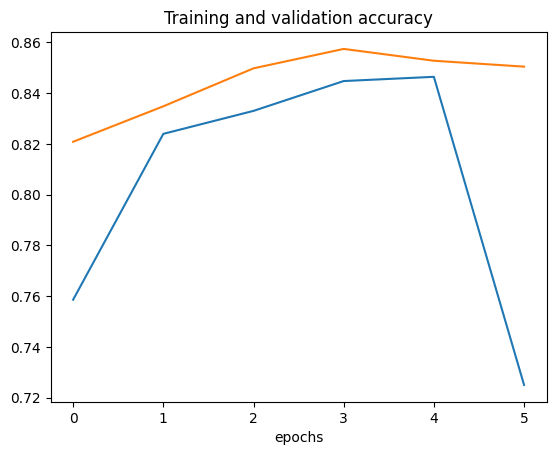

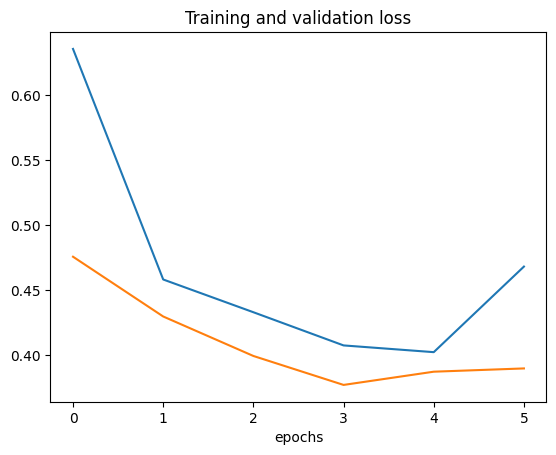

In [38]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = len(history.history['loss'])
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.plot(accuracy, label = 'accuracy')
    plt.plot(val_accuracy, label = 'val_accuracy')
    plt.xlabel('epochs')
    plt.title('Training and validation accuracy')
    plt.figure()
    plt.plot(loss, label = 'loss')
    plt.plot(val_loss, label = 'val_loss')
    plt.xlabel('epochs')
    plt.title('Training and validation loss')
plot_loss_curves(history)

**Here it seems that our model performed best at epoch 4. (around 85% accuracy which is > 80%).\n**
  **Now let us make some predictions on validation dataset.**

In [39]:
model_pred_probs = model.predict(val_char_token_pos_dataset)
model_preds = tf.argmax(model_pred_probs, axis = 1)


945/945 [==============================] - 18s 16ms/step


In [40]:
len(val_labels_encoded)

30212

In [41]:
model_result = calculate_result(val_labels_encoded, model_preds[:])
model_result

{'accuracy': 0.8514828544949027,
 'precision': 0.8532350465220061,
 'recall': 0.8514828544949027,
 'f1_score': 0.8487431178298619}

In [42]:
val_pred_classes = [label_encoder.classes_[pred] for pred in model_preds]
val_pred_classes[:20]

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS']

**Final function which takes a text(paragraph) as input and labels it accordingly to make our reading more understandable**

In [43]:
def make_prediction(text):
    from spacy.lang.en import English
    nlp = English()
    sentencizer = nlp.add_pipe('sentencizer')
    doc = nlp(text) 
    abstract_lines = [str(sent) for sent in list(doc.sents)] 
    test_chars = [char_split(sentence) for sentence in abstract_lines]
    sample_lines = []
    for i, line in enumerate(abstract_lines):
      sample_dict = {}
      sample_dict["text"] = str(line)
      sample_dict["line_number"] = i
      sample_dict["total_lines"] = len(abstract_lines) - 1
      sample_lines.append(sample_dict)
    sample_df = pd.DataFrame(sample_lines)
    test_line_number_one_hot = tf.one_hot(sample_df['line_number'].to_numpy(), depth = 15)
    test_total_lines_one_hot = tf.one_hot(sample_df['total_lines'].to_numpy(), depth = 20)
    final_test_pred_probs = model.predict(x = (test_line_number_one_hot,
                  test_total_lines_one_hot,
                  tf.constant(abstract_lines),
                  tf.constant(test_chars)))
    final_test_preds = tf.argmax(final_test_pred_probs, axis = 1)
    final_test_preds_classes = [label_encoder.classes_[i] for i in final_test_preds]
    for i, line in enumerate(abstract_lines):
        print(f"{final_test_preds_classes[i]}: {line}")
    


**Now we are going to make the predictions on the random paragraph across the web.**
**Paragraph:    *This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.*'**

In [44]:
para1 = make_prediction('This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.')

1/1 [==============================] - 3s 3s/step
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored th

In [45]:
para2 = make_prediction('Randomized-controlled trials (RCTs) are advocated to provide high-level medical evidence. However, in neurosurgery, there are barriers to conducting RCTs. The authors of this study sought to analyze the quality of neurosurgical RCTs since 2000 to determine the adequacy of their design and reporting.A search of the MEDLINE and EMBASE databases (2000-2014) was conducted. The medical subject heading (MeSH) terms used in the search included: "neurosurgery" OR "neurosurgical procedure," "brain neoplasms," "infarction" and "decompression," "carotid stenosis," "cerebral hemorrhage," and "spinal fusion." These studies were limited to RCTs, in humans, and in the English language. The Consolidated Standards for Reporting of Trials (CONSORT) and Jadad scales were used to assess the quality of RCT design and reporting. The standardized median times cited (median citations divided by years since publication) were used to assess impact. A pragmatic-explanatory continuum indicator summary-based scale was used to assess the design of the studies as primarily pragmatic or explanatory.Sixty-one articles were identified, and the following subspecialties were the most common: vascular (23, 37%), followed by functional neurosurgery and neurooncology (both 13, 21%). The following nations were the primary leaders in RCTs: US (25 studies, 41%), Germany (8 studies, 13%), and the United Kingdom (7 studies, 11%). Median sample size was 100 (interquartile range [IQR] 41.5-279). The majority of the studies (40, 66%) had pragmatic objectives. The median number of times cited overall was 69 (IQR 20.5-193). The combined median CONSORT score was 36 (IQR 27.5-39). Blinding was most deficiently reported. Other areas with a relatively low quality of reporting were sample size calculation (34.2% of surgical, 38.5% of drug, and 20% of device studies), allocation concealment (28.9% of surgical, 23.1% of drug, and 50% of device studies), and protocol implementation (18.4% of surgical, 23% of drug, and 20% of device studies). The quality of reporting did not correlate with the study impact. All studies had a median Jadad score ≤ 3. Thirty-three pragmatic studies (83%) and 5 explanatory studies (25%) met the design objectives. All pragmatic studies based on drug and device trials met their objectives, while 74% of pragmatic surgical trials met their objectives.The prevalence of neurosurgical RCTs is low. The quality of RCT design and reporting in neurosurgery is also low. Many study designs are not compatible with stated objectives. Pragmatic studies were more likely to meet design objectives. Given the role of RCTs as one of the highest levels of evidence, it is critical to improve on their methodology and reporting.The prevalence of neurosurgical RCTs is low. The quality of RCT design and reporting in neurosurgery is also low. Many study designs are not compatible with stated objectives. Pragmatic studies were more likely to meet design objectives. Given the role of RCTs as one of the highest levels of evidence, it is critical to improve on their methodology and reporting.')

1/1 [==============================] - 0s 35ms/step
BACKGROUND: Randomized-controlled trials (RCTs) are advocated to provide high-level medical evidence.
BACKGROUND: However, in neurosurgery, there are barriers to conducting RCTs.
OBJECTIVE: The authors of this study sought to analyze the quality of neurosurgical RCTs since 2000 to determine the adequacy of their design and reporting.
METHODS: A search of the MEDLINE and EMBASE databases (2000-2014) was conducted.
METHODS: The medical subject heading (MeSH) terms used in the search included: "neurosurgery" OR "neurosurgical procedure," "brain neoplasms," "infarction" and "decompression," "carotid stenosis," "cerebral hemorrhage," and "spinal fusion."
METHODS: These studies were limited to RCTs, in humans, and in the English language.
METHODS: The Consolidated Standards for Reporting of Trials (CONSORT) and Jadad scales were used to assess the quality of RCT design and reporting.
RESULTS: The standardized median times cited (median cita